In [ ]:
"""
QUESTON 2:
                DO OPENINGS AFFECT GAME LENGTH OR DRAW LIKELIHOOD?   
"""

In [ ]:
"""
MACHINE LEARNING 

    Models: 
        Regression: Target variable (y) = "turns"
            Models average change in game length

        Random Forest Regressor: 
            Capture nonlinear effects 
        
"""

In [63]:
#Load dataset 

import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error

games = pd.read_csv("/Users/exequielfleitas/data/chess_games.csv")

games.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [65]:
# Create "rating_diff" column 
games["rating_diff"] = (
    games["white_rating"] - games["black_rating"] )

In [67]:
# Clean the dataset 

# Drop rows with missing values 
games = games.dropna(subset = ["turns"])

# Ensure that key numeric columns are numeric!
games["turns"] = pd.to_numeric(games["turns"], errors = "coerce")
games["rating_diff"] = pd.to_numeric(games["rating_diff"], errors = "coerce")
games["opening_ply"] = pd.to_numeric(games["opening_ply"], errors = "coerce")

# Remove any rows where turns became NaN
games = games.dropna(subset = ["turns"])


# Make "rated" variable a binary variable 
games["rated"] = games["rated"].astype(int)

games.head(2)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,rating_diff
0,TZJHLljE,0,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,309
1,l1NXvwaE,1,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,61


In [69]:
#Filter out not common ECO codes (ECO Codes < 100)

MIN_ECO_COUNT = 100

eco_counts = games["opening_eco"].value_counts()
common_ecos = eco_counts[eco_counts >= MIN_ECO_COUNT].index

games["opening_eco_filtered"] = games["opening_eco"].where(games["opening_eco"].isin(common_ecos),
                                                           "Other"
                                                          )

In [71]:
# Define X and y 

features = [
    "rating_diff",
    "opening_ply",
    "rated",
    "increment_code",
    "opening_eco_filtered"
]

X = games[features].copy()
y = games["turns"].copy()

In [73]:
# Train & split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [75]:
# Processing 
numeric_features = ["rating_diff", "opening_ply"]
binary_features = ["rated"]
categorical_features = ["increment_code", "opening_eco_filtered"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("bin", "passthrough", binary_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [85]:
# Linear Regression 

linreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

linreg_model.fit(X_train, y_train)

y_pred_lr = linreg_model.predict(X_test)

lr_r2 = r2_score(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("=== Linear Regression ===")
print("R²:", lr_r2)
print("RMSE (turns):", lr_rmse)


=== Linear Regression ===
R²: 0.016003966359653177
RMSE (turns): 33.29827802408164


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
"""
R²: 0.016
    The linear model explains about 1.6% of the variation in game length
RMSE: 33.30 turns 
    On average, the predicitons are off by ~33 half moves

Game length is very nosiy 
No strong linear relationshop between the features and number of turns 

Conclusion: Openings do not have a strong linear effect on game length, 
            but this does not rule out more complex patterns.

"""

In [87]:
# Random Forest Regressor 

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=5
    ))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\n=== Random Forest Regressor ===")
print("R²:", rf_r2)
print("RMSE (turns):", rf_rmse)



=== Random Forest Regressor ===
R²: 0.04135505097998049
RMSE (turns): 32.86654067506467


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
"""
R²: 0.041
    About 4.1% of variance in game length
RMSE: 32.87 turns 

Conclusion:
    While game length remains difficult to predict precisely, 
    the Random Forest model captures more structure than a linear model, 
    suggesting that opening choice contributes to game length in nonlinear and conditional ways.
"""


In [88]:
# Compare both models 
print("\n=== Comparison ===")
print(f"Linear Regression  -> R²: {lr_r2:.4f}, RMSE: {lr_rmse:.2f}")
print(f"Random Forest      -> R²: {rf_r2:.4f}, RMSE: {rf_rmse:.2f}")


=== Comparison ===
Linear Regression  -> R²: 0.0160, RMSE: 33.30
Random Forest      -> R²: 0.0414, RMSE: 32.87


In [89]:
# Shows which openings are the longest!
eco_summary = (
    games.groupby("opening_eco_filtered")["turns"]
    .agg(["count", "mean", "median"])
    .sort_values("mean", ascending=False)
)

print("\n=== Top 10 openings by average turns ===")
print(eco_summary.head(10))

print("\n=== Bottom 10 openings by average turns ===")
print(eco_summary.tail(10))



=== Top 10 openings by average turns ===
                      count       mean  median
opening_eco_filtered                          
B90                     101  68.653465    62.0
B40                     129  68.348837    63.0
B50                     226  67.101770    63.0
B06                     176  66.602273    61.0
C62                     137  66.467153    62.0
D10                     110  65.963636    60.0
A45                     252  65.690476    58.0
B30                     227  64.735683    58.0
B12                     167  64.730539    59.0
D02                     434  64.211982    60.0

=== Bottom 10 openings by average turns ===
                      count       mean  median
opening_eco_filtered                          
C45                     284  56.647887    49.0
B01                     716  56.389665    52.0
C42                     327  55.804281    53.0
A00                    1007  55.750745    52.0
C21                     172  55.255814    48.0
C20                 

In [ ]:
"""
The R² is low because game length may be influenced by other factors like:
    Mistakes 
    Trades
    Midgame plans 
    Endgame technique
    Psychological decisions 

    Openings only shape the initial structure, NOT the whole game 
    A low R² does not mean openings don’t matter — it means they are one of many factors.

Conclusion:
    While chess openings do not strongly determine game outcomes, they do influence the structure and 
    length of games. Linear models show weak average effects, but a Random Forest regression captures 
    nonlinear relationships between opening choice and game length. Descriptive analysis reveals that 
    theoretical, positional openings such as the Sicilian Najdorf and Ruy Lopez are associated with 
    longer games, while tactical or irregular openings tend to produce shorter games. Overall, 
    opening choice shapes how a game unfolds rather than decisively determining its result.
    

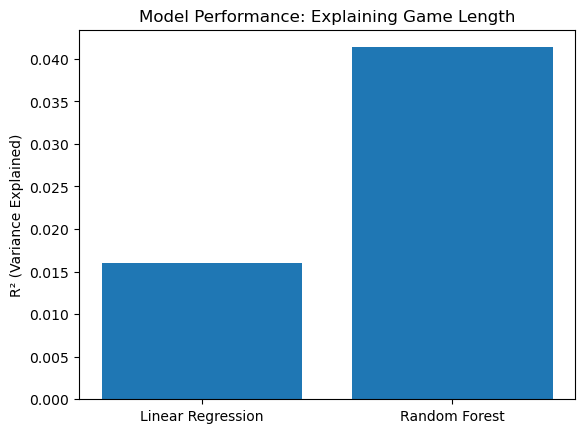

In [93]:
# R² Comparison Bar Chart
import matplotlib.pyplot as plt

model_names = ["Linear Regression", "Random Forest"]
r2_values = [0.016003966359653177, 0.04135505097998049]

plt.figure()
plt.bar(model_names, r2_values)
plt.ylabel("R² (Variance Explained)")
plt.title("Model Performance: Explaining Game Length")
plt.show()

In [ ]:
"""
Linear regression explains very little of the variation in game length, 
while Random Forest performs noticeably better, indicating that opening effects 
are nonlinear and interactive.

"""

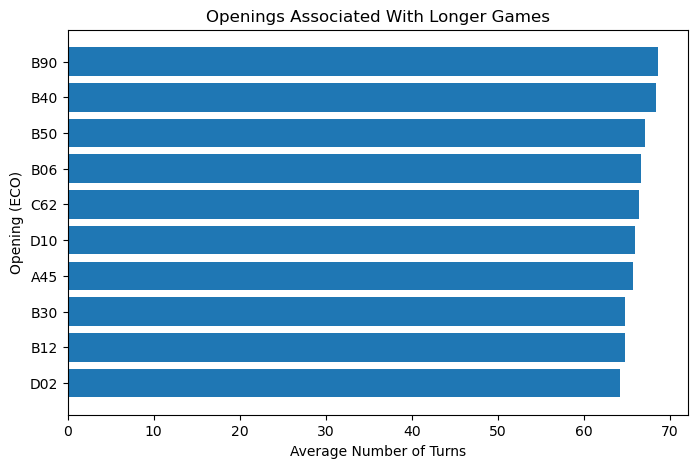

In [95]:
eco_summary = (
    games.groupby("opening_eco_filtered")["turns"]
    .agg(["count", "mean"])
    .query("count >= 100")
    .sort_values("mean", ascending=False)
)

top10 = eco_summary.head(10)

plt.figure(figsize=(8, 5))
plt.barh(top10.index, top10["mean"])
plt.xlabel("Average Number of Turns")
plt.ylabel("Opening (ECO)")
plt.title("Openings Associated With Longer Games")
plt.gca().invert_yaxis()
plt.show()


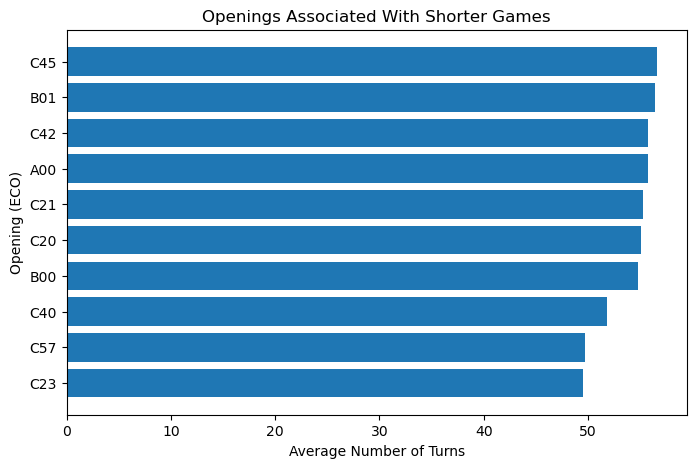

In [97]:
bottom10 = eco_summary.tail(10)

plt.figure(figsize=(8, 5))
plt.barh(bottom10.index, bottom10["mean"])
plt.xlabel("Average Number of Turns")
plt.ylabel("Opening (ECO)")
plt.title("Openings Associated With Shorter Games")
plt.gca().invert_yaxis()
plt.show()

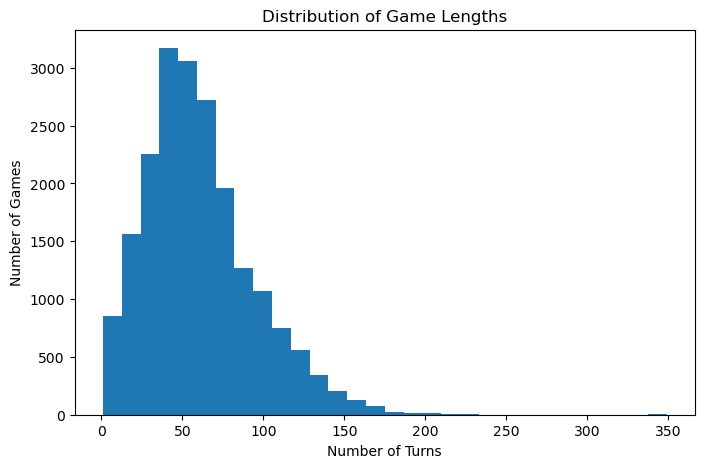

In [99]:
plt.figure(figsize=(8, 5))
plt.hist(games["turns"], bins=30)
plt.xlabel("Number of Turns")
plt.ylabel("Number of Games")
plt.title("Distribution of Game Lengths")
plt.show()


In [ ]:
"""
FINAL CONCLUSION:
This project investigated whether chess opening choice meaningfully influences game outcomes and 
game structure using supervised machine learning models applied to a large dataset of online chess 
games. Initial classification models showed that player rating and time control were the dominant 
predictors of game outcome, while opening choice—whether represented by ECO families or full 
ECO codes—did not improve predictive performance once player skill was controlled for. 
This suggests that openings do not independently determine who wins a game, and that their apparent 
effectiveness is largely explained by stronger players selecting stronger openings.

Given these findings, the analysis was reframed to examine whether openings influence how games unfold, 
rather than who wins. Treating game length (number of turns) as a regression problem revealed more 
meaningful patterns. While a linear regression model explained very little variation in game length, 
a Random Forest regressor captured nonlinear relationships and performed better, indicating that 
opening choice contributes to game structure in more complex ways. Descriptive analysis supported 
these results, showing that theoretical and positional openings such as the Sicilian Najdorf, 
Ruy Lopez variations, and Slav structures are associated with longer games, while 
irregular or tactical openings tend to result in shorter, more decisive games.

Overall, the results suggest that chess openings shape the character of a game rather than 
its final result. Player strength remains the primary determinant of winning, but opening choice 
plays a meaningful role in influencing game length and complexity. This highlights the importance 
of careful problem framing in data science: while some factors may not predict outcomes directly, 
they can still exert a significant influence on underlying structure and dynamics.

"""